# ETL Pipeline

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sqlalchemy import create_engine

# **Extracción de Datos**

**Extraccion de datos de API de Taylor**

In [ ]:
def extract_api(url):
  response = requests.get(url)
  if response.status_code == 200:
      data = response.json()
      return data
  else:
      print(f"Error: {response.status_code}")

**Extraccion de datos de la tienda oficial de Taylor**

In [ ]:
# Funcion usando solo url
def get_taylor_shop(url):
  page = requests.get(url)
  soup = BeautifulSoup(page.content,"html.parser")

  productos = soup.find_all("div", class_="ProductItem__Wrapper")
  productos

  productos_list = []
  for p in productos:
    col = {}
    name = p.find("h2",class_="ProductItem__Title Heading").find('a').text
    price = p.find("div",class_="ProductItem__PriceList Heading")

    col['Nombre'] = name

    if price:
      col['Precio'] = price.find('span',class_="ProductItem__Price Price Text--subdued").text
    else:
      col['Precio'] = None

    productos_list.append(col)

  productos_df = pd.DataFrame(productos_list)
  return   productos_df

In [ ]:
def extract_web(urls):
  # Recopilacion de productos segun album
  dataframes_list = []

  for url in urls:
    df = get_taylor_shop(url)
    dataframes_list.append(df)

  return dataframes_list

**Extraccion de datos de los archivos CSV de Taylor extraídos de Kaggle**

In [ ]:
def extract_csv(ruta):
  df = pd.read_csv(ruta, encoding='latin1')
  return df

#**Transformación de Datos**

In [ ]:
def transform_api(data_songs,data_albums):
  # Creacion de DataFrames
  df_albums = pd.DataFrame(data_albums)
  df_songs = pd.DataFrame(data_songs)

  # Transformando df_albums
  if 'release_date' in df_albums.columns:
    df_albums['release_date'] = pd.to_datetime(df_albums['release_date'])
    df_albums['year'] = df_albums['release_date'].dt.year
    df_albums['month'] = df_albums['release_date'].dt.month
    df_albums['day'] = df_albums['release_date'].dt.day
    df_albums = df_albums.drop('release_date', axis=1)

  # Data Integration
  merged_df = pd.merge(df_songs, df_albums, on='album_id', how='left')
  merged_df = merged_df.drop(['album_id'], axis=1)
  merged_df = merged_df.drop(['song_id'], axis=1)
  merged_df = merged_df.rename(columns={
      'title_x': 'song_title',
      'title_y': 'album_title',
      'year': 'album_year',
      'month': 'album_month',
      'day': 'album_day'
  })
  return merged_df

In [ ]:
def transform_web(dataframes_list):
  # Agregamos la columna 'Album' para distinguir a qué álbum pertenece cada dato
  for album_name, df in zip(['Taylor Swift', 'Fearless', 'Speak Now', 'Red', '1989', 'Reputation', 'Lover', 'Folklore', 'Evermore', 'Midnights'], dataframes_list):
        df['Album'] = album_name

  shop_df = pd.concat(dataframes_list, ignore_index=True)
  shop_df['Precio'] = shop_df['Precio'].str.replace('$', '')
  shop_df['Precio'] = shop_df['Precio'].astype(float)
  return shop_df

In [ ]:
def transform_csv(name_df, df):
  if name_df == 'emociones_df':
    # Eliminamos primera columna
    df = df.iloc[:, 1:]

    # Eliminamos las columnas 'id' y 'uri'
    df.drop(['id', 'uri'], axis=1, inplace=True)

    # Renombramos las columnas
    column_names_es = {
        'name': 'Nombre',
        'album': 'Album',
        'release_date': 'Fecha_de_Lanzamiento',
        'track_number': 'Numero_de_Pista',
        'acousticness': 'Acustica',
        'danceability': 'Bailabilidad',
        'energy': 'Energia',
        'instrumentalness': 'Instrumentalidad',
        'liveness': 'Vitalidad',
        'loudness': 'Volumen',
        'speechiness': 'Caracter_hablado',
        'tempo': 'Tempo',
        'valence': 'Valencia',
        'popularity': 'Popularidad',
        'duration_ms': 'Duracion'
    }
    df.rename(columns=column_names_es, inplace=True)

    # Convertimos la duración de milisegundos a minutos
    df['Duracion'] = round(df['Duracion'] / 60000, 2)

    # Duración en minutos al formato 3:37
    def formatear_duracion(duracion):
        minutos = int(duracion)
        segundos = int((duracion - minutos) * 60)
        return f"{minutos}:{segundos:02d}"

    # Aplica la función personalizada
    df['Duracion'] = df['Duracion'].apply(formatear_duracion)

    # Filtramos el DataFrame para incluir solo ciertos álbumes
    albums_to_include = [
        "Taylor Swift", "Fearless", "Speak Now", "Red", "1989",
        "reputation", "Lover", "folklore", "evermore", "Midnights"
    ]
    df = df[df['Album'].isin(albums_to_include)]

    # Researt indices
    df.reset_index(drop=True, inplace=True)
    return df
  elif name_df == 'valbums_df':
    df.rename(columns={
        "Album": "Album",
        "Continent": "Continente",
        "Country": "Pais",
        "Sales": "Ventas",
        "Pure_sales_index": "Indice_de_Ventas_Puras"
    }, inplace=True)
    return df



# **Carga de Datos**

Datos almacenados en MySQL

In [ ]:
# Permite ingresar el nombre de la tabla que vamos a crear
def load_sqlite(df,table_name):
  """ Loads data into a sqllite database"""
  disk_engine = create_engine('sqlite:///taylor_data.db')
  df.to_sql(table_name, disk_engine, if_exists='replace')

# ETL final

## **API**

Ya no se puede usar la api debido a que la eliminaron, pero aun así lo hemos considerado en el ETL pipeline. Antes de que sea eliminada, logramos extraer la data y el csv, así que lo consideraremos solo como archivo CSV para la carga de
 datos.

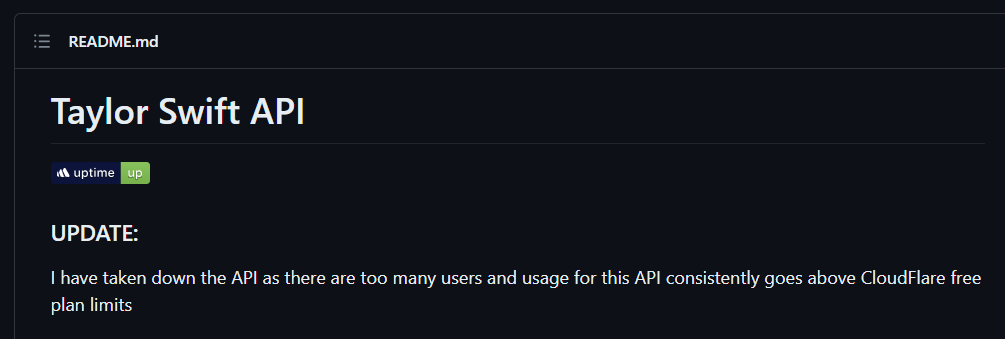

In [ ]:
# No correr
albums_url = "https://taylor-swift-api.sarbo.workers.dev/albums"
albums_data = extract_api(albums_url)

In [ ]:
# No correr
songs_url = "https://taylor-swift-api.sarbo.workers.dev/songs"
songs_data = extract_api(songs_url)

In [ ]:
# NO correr
result = transform_api(songs_data, albums_data)

In [ ]:
# Considerandolo como CSV para la extraccion y carga
# No se realiza la transformacion en csv, porque ya esta hecha en transform_api()
songs_albums_df = extract_csv('/content/api_lanzamiento_album.csv')

In [ ]:
load_sqlite(songs_albums_df,'api_music_data')

## **Web Scraping**

In [ ]:
# Lista de URLs de los álbumes
album_urls = [
    'https://store.taylorswift.com/collections/taylor-swift-album-shop',
    'https://store.taylorswift.com/collections/fearless-taylors-version-shop',
    'https://store.taylorswift.com/collections/speak-now-shop-1',
    'https://store.taylorswift.com/collections/red-taylors-version-shop',
    'https://store.taylorswift.com/collections/1989-shop-1',
    'https://store.taylorswift.com/collections/reputation-shop',
    'https://store.taylorswift.com/collections/lover-album-shop',
    'https://store.taylorswift.com/collections/folklore-album-shop',
    'https://store.taylorswift.com/collections/taylor-swift-evermore-album-shop',
    'https://store.taylorswift.com/collections/taylor-swift-midnights-album-shop-1'
]

In [ ]:
# No correr, puede fallar
dfs_list = extract_web(album_urls)

La transformación de la data puede salir error porque las etiquetas cambian por temas de cyber monday, black friday, etc. Pero considerando la data ya extraida, usaremos el CSV.

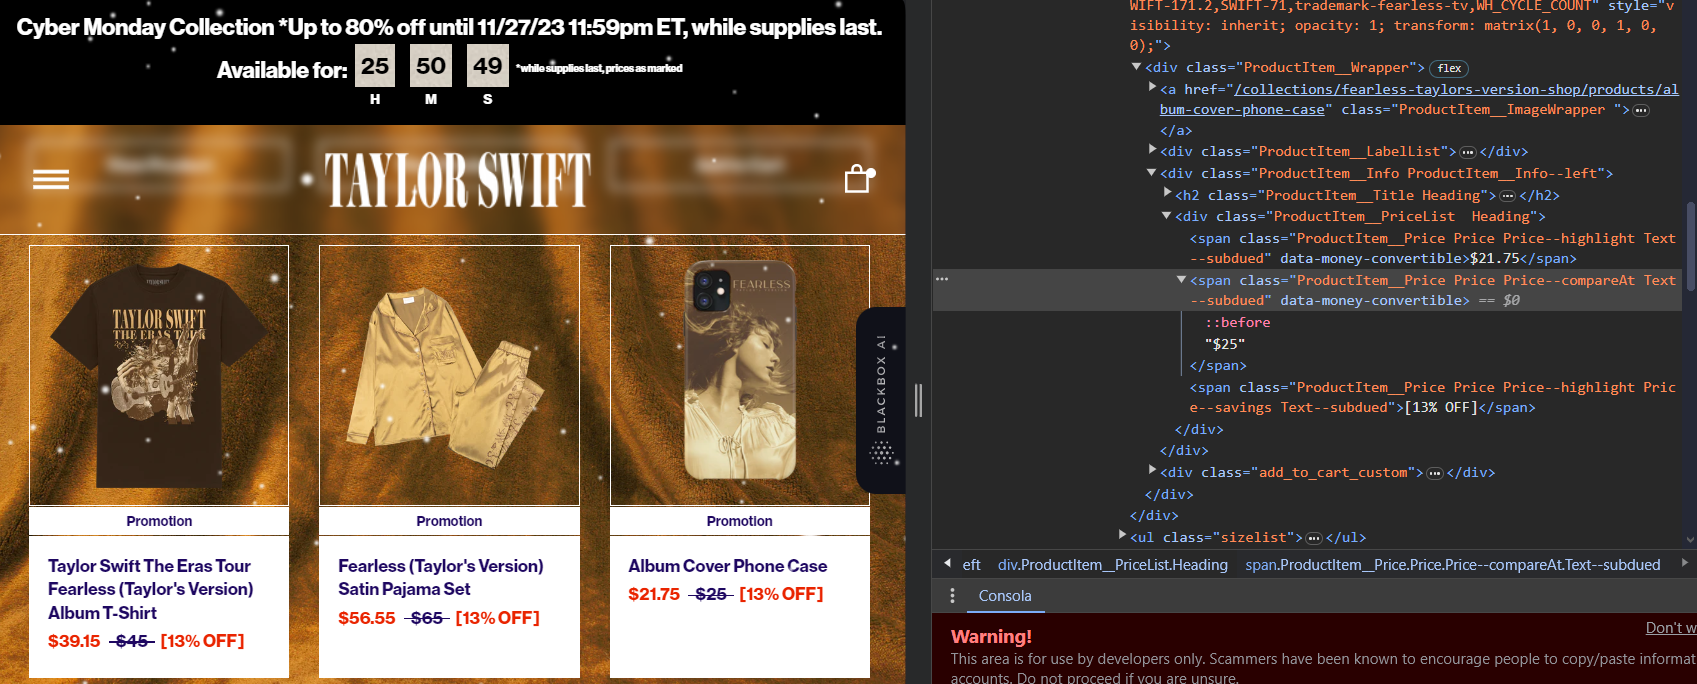

In [ ]:
transform_web(dfs_list)

In [ ]:
# Usando el CSV del Web Scraping de Taylor, debido a los cambios en la página web
# Solo utilizaremos la extraccion y carga
shop_df = extract_csv('/content/ws_taylor_store.csv')

In [ ]:
load_sqlite(shop_df,'ws_store')

## **Archivos CSV**

In [ ]:
# DataFrames que no transformaremos
h1_df = extract_csv('/content/h1_feats.csv')
h2_df = extract_csv('/content/h2_genero_discografica.csv')
lyrics_df = extract_csv('/content/taylor_swift_lyrics.csv')

In [ ]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4862 entries, 0 to 4861
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist       4862 non-null   object
 1   album        4862 non-null   object
 2   track_title  4862 non-null   object
 3   track_n      4862 non-null   int64 
 4   lyric        4862 non-null   object
 5   line         4862 non-null   int64 
 6   year         4862 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 266.0+ KB


In [ ]:
h2_df

,Album,Year,Genero,Re_grabacion,Productor,Estudio,Discografica
0,Taylor Swift,2006,Country,No,"Nathan Chapman, Robert Ellis","Castles, Quad, Sound Cottage, Sound Emporium",Big Machine
1,Evermore,2020,"Alternative Rock, Chamber Rock, Folk-pop, Indi...",No,"Aaron Dessner, Taylor Swift, Jack Antonoff, Br...","Kitty Committee, Long Pond, Scarlet Pimpernel,...",Republic
2,Fearless,2008,Country Pop,No,"Nathan Chapman, Taylor Swift","Blackbird, Fool on the Hill, Quad, Sound Cotta...",Big Machine
3,Folklore,2020,"Indie Folk, Alternative Rock, Electro-folk, Ch...",No,"Aaron Dessner, Jack Antonoff, Taylor Swift, Jo...","Conways, Kitty Committee, Electric Lady, Long ...",Republic
4,Lover,2019,"Electropop, Pop Rock, Synth-pop",No,"Taylor Swift, Jack Antonoff, Joel Little, Loui...","Conways Recordings, Electric Lady, Golden Age ...",Republic
5,Midnights,2022,"Synth-pop, Electropop, Bedroom Pop, Dream Pop",No,"Taylor Swift, Jack Antonoff, Sounwave, Jahaan ...","Audu, Big Mercy, Blue Plate, Electric Lady, Hu...",Republic
6,Red,2012,"Pop, Country, Rock",No,"Taylor Swift, Nathan Chapman, Jeff Bhasker, Da...","Blackbird, Pain in the Art, Ballroom West, Ins...",Big Machine
7,Reputation,2017,"Electropop, R&B",No,"Taylor Swift, Max Martin, Shellback, Jack Anto...","Conway Recordings, MXM, Rough Customer, Seismi...",Big Machine
8,Speak Now,2010,"Country Pop, Pop Rock, Power Pop",No,"Nathan Chapman, Taylor Swift","Aimeeland, Blackbird, Pain in the Art, Starstr...",Big Machine
9,1989,2014,Synth-pop,No,"Max Martin, Taylor Swift, Shellback, Jack Anto...","Conway Recordings, Jungle City, Lamby's House,...",Big Machine


In [ ]:
load_sqlite(h1_df,'feats')

In [ ]:
load_sqlite(h2_df,'albums')

In [ ]:
load_sqlite(lyrics_df,'lyrics_info')

### Spotify data emociones

In [ ]:
# DataFrame que si limpiaremos
emociones_df = extract_csv('/content/spotify.csv')
emociones_df.head(3)

,Unnamed: 0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,0,Welcome To New York (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,1,4WUepByoeqcedHoYhSNHRt,spotify:track:4WUepByoeqcedHoYhSNHRt,0.009420,0.757,0.610,0.000037,0.3670,-4.840,0.0327,116.998,0.685,80,212600
1,1,Blank Space (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,2,0108kcWLnn2HlH2kedi1gn,spotify:track:0108kcWLnn2HlH2kedi1gn,0.088500,0.733,0.733,0.000000,0.1680,-5.376,0.0670,96.057,0.701,80,231833
2,2,Style (Taylor's Version),1989 (Taylor's Version) [Deluxe],2023-10-27,3,3Vpk1hfMAQme8VJ0SNRSkd,spotify:track:3Vpk1hfMAQme8VJ0SNRSkd,0.000421,0.511,0.822,0.019700,0.0899,-4.785,0.0397,94.868,0.305,81,231000


In [ ]:
emociones_df = transform_csv('emociones_df',emociones_df)

In [ ]:
#Verificando que se haya realizado la transformación
emociones_df.head(3)

,Nombre,Album,Fecha_de_Lanzamiento,Numero_de_Pista,Acustica,Bailabilidad,Energia,Instrumentalidad,Vitalidad,Volumen,Caracter_hablado,Tempo,Valencia,Popularidad,Duracion
0,Lavender Haze,Midnights,2022-10-21,1,0.2580,0.733,0.436,0.000573,0.157,-10.489,0.0800,96.985,0.0976,86,3:22
1,Maroon,Midnights,2022-10-21,2,0.0573,0.637,0.398,0.000001,0.101,-8.294,0.0564,108.075,0.0374,82,3:38
2,Anti-Hero,Midnights,2022-10-21,3,0.1300,0.637,0.643,0.000002,0.142,-6.571,0.0519,97.008,0.5330,93,3:20


In [ ]:
emociones_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Nombre                148 non-null    object 
 1   Album                 148 non-null    object 
 2   Fecha_de_Lanzamiento  148 non-null    object 
 3   Numero_de_Pista       148 non-null    int64  
 4   Acustica              148 non-null    float64
 5   Bailabilidad          148 non-null    float64
 6   Energia               148 non-null    float64
 7   Instrumentalidad      148 non-null    float64
 8   Vitalidad             148 non-null    float64
 9   Volumen               148 non-null    float64
 10  Caracter_hablado      148 non-null    float64
 11  Tempo                 148 non-null    float64
 12  Valencia              148 non-null    float64
 13  Popularidad           148 non-null    int64  
 14  Duracion              148 non-null    object 
dtypes: float64(9), int64(2)

In [ ]:
load_sqlite(emociones_df,'spotify_emociones')

### Ventas de Albumes

In [ ]:
# DataFrames que si limpiaremos
valbums_df = extract_csv('/content/albumsales.csv')

In [ ]:
valbums_df = transform_csv('valbums_df',valbums_df)

In [ ]:
valbums_df.head(3)

,Album,Year,Continente,Pais,Ventas,Indice_de_Ventas_Puras
0,Taylor Swift,2006,Asia,Afghanistan,42.0,0.042
1,Taylor Swift,2007,Asia,Afghanistan,27.0,0.027
2,Taylor Swift,2008,Asia,Afghanistan,27.0,0.027


In [ ]:
valbums_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8280 entries, 0 to 8279
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Album                   8280 non-null   object 
 1   Year                    8280 non-null   int64  
 2   Continente              8280 non-null   object 
 3   Pais                    8280 non-null   object 
 4   Ventas                  8280 non-null   float64
 5   Indice_de_Ventas_Puras  8280 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 388.2+ KB


In [ ]:
load_sqlite(valbums_df,'ventas_albums')